In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from pyspark.sql.types import IntegerType, FloatType ,DateType
from pyspark.sql import SparkSession, DataFrame
import findspark
import pyspark.sql.functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import *
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

In [2]:
findspark.init()
findspark.find()

'C:\\Spark\\spark-3.0.3-bin-hadoop2.7'

In [3]:
spark = SparkSession \
    .builder \
    .appName("Practice pyspark 2") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
df = spark.read.csv(".\data\practive pyspark.csv", header =True)
df.show(5)
df.printSchema()

+----+--------+------+---+---------+--------------+---------+-------+------------+-----------+------------+------+------------+-----------+-------------+--------------------+-----------------+-----------------+----------+------------------+-----------------+--------------------+-----------------+
|Code|    area|gender|age|age_group|year_of_school|   degree|    job|know_english|know_france|know_chinese|income|booking_date|flight_date|flight_status|professionally_staff|customer_service |diversity_product|good_price|easily_transaction|goodlooking_staff|diversity_flighttime|good_construction|
+----+--------+------+---+---------+--------------+---------+-------+------------+-----------+------------+------+------------+-----------+-------------+--------------------+-----------------+-----------------+----------+------------------+-----------------+--------------------+-----------------+
|   1| central|female| 69|   middle|            16|   master|manager|           1|          1|           1

# Clean data

In [5]:
#Convering str to numberic
df = df.withColumn('Code', F.col('Code').cast(IntegerType()))\
        .withColumn('age', F.col('age').cast(IntegerType()))\
        .withColumn('year_of_school',F.col('year_of_school').cast(IntegerType()))\
        .withColumn('know_english', F.col('know_english').cast(IntegerType()))\
        .withColumn('know_france', F.col('know_france').cast(IntegerType()))\
        .withColumn('know_chinese', F.col('know_chinese').cast(IntegerType()))\
        .withColumn('income', F.col('income').cast(IntegerType()))\
        .withColumn('flight_status', F.col('flight_status').cast(IntegerType()))\
        .withColumn('professionally_staff', F.col('professionally_staff').cast(IntegerType()))\
        .withColumn('customer_service ', F.col('customer_service ').cast(IntegerType()))\
        .withColumn('diversity_product', F.col('diversity_product').cast(IntegerType()))\
        .withColumn('good_price', F.col('good_price').cast(IntegerType()))\
        .withColumn('easily_transaction', F.col('easily_transaction').cast(IntegerType()))\
        .withColumn('goodlooking_staff', F.col('goodlooking_staff').cast(IntegerType()))\
        .withColumn('diversity_flighttime', F.col('diversity_flighttime').cast(IntegerType()))\
        .withColumn('good_construction', F.col('good_construction').cast(IntegerType()))
df.printSchema()

root
 |-- Code: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- year_of_school: integer (nullable = true)
 |-- degree: string (nullable = true)
 |-- job: string (nullable = true)
 |-- know_english: integer (nullable = true)
 |-- know_france: integer (nullable = true)
 |-- know_chinese: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- booking_date: string (nullable = true)
 |-- flight_date: string (nullable = true)
 |-- flight_status: integer (nullable = true)
 |-- professionally_staff: integer (nullable = true)
 |-- customer_service : integer (nullable = true)
 |-- diversity_product: integer (nullable = true)
 |-- good_price: integer (nullable = true)
 |-- easily_transaction: integer (nullable = true)
 |-- goodlooking_staff: integer (nullable = true)
 |-- diversity_flighttime: integer (nullable = true)
 |-- good_construction: integer

# 1. phân tích tương quan giữa thu nhập, tuổi, số năm đi học của kh

In [6]:
data = df.select("age","income","year_of_school")

In [7]:
data.show(3)

+---+------+--------------+
|age|income|year_of_school|
+---+------+--------------+
| 69| 33250|            16|
| 50|  6960|            12|
| 73| 11100|            12|
+---+------+--------------+
only showing top 3 rows



In [8]:
data_df = data.toPandas() 

In [9]:
corr = data_df.corr()

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'age'), Text(0, 1.5, 'income'), Text(0, 2.5, 'year_of_school')])

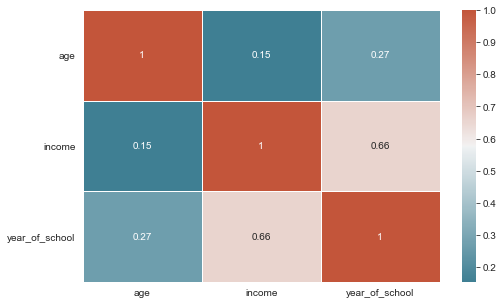

In [10]:
plt.subplots(figsize = (8,5))
sns.heatmap(corr, xticklabels=["age","income","year_of_school"]
            ,yticklabels=["age","income","year_of_school"], annot = True,
            linewidths = 0.5, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.yticks(rotation=0)

Biến income và biến year_of_school có độ tương bằng 0.66, vậy thu nhập có mối liên hệ positive với biến trung bình số lương đi học. Thu nhập tăng số năm đi học tăng

# 2. tạo cột nhóm thu nhập với điều kiện
-  income < 9000 -> low income
-  9000 < income < 15000 -> medium income
-  >15000 -> high income

Thống kê số lượng kh của từng nhóm

In [11]:
df = df.withColumn("Type income", \
   when((df.income < 9000), lit("low income")) \
     .when((df.income >= 9000) & (df.income < 15000), lit("medium income")) \
     .otherwise(lit("high income")))


In [12]:
df.select('income','Type income').show(5)

+------+-------------+
|income|  Type income|
+------+-------------+
| 33250|  high income|
|  6960|   low income|
| 11100|medium income|
| 11100|medium income|
| 16140|  high income|
+------+-------------+
only showing top 5 rows



In [13]:
income = df.select("income",'Type Income')

In [14]:
income_df = income.toPandas()

<AxesSubplot:xlabel='Type Income', ylabel='income'>

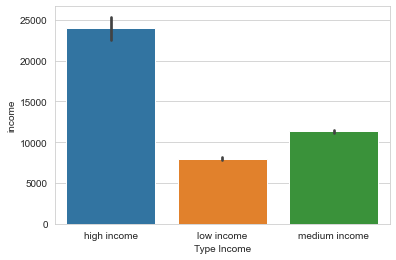

In [15]:
sns.barplot(y = income_df['income'], x = income_df['Type Income'] )

# 3. tính khoảng cách theo ngày giữa thời gian đặt vé và thời gian bay của kh

In [16]:
df = df.withColumn("date_flight",to_date(col("flight_date"),"dd/MM/yyyy"))

In [17]:
df = df.withColumn("date_booking",to_date(col("booking_date"),"dd/MM/yyyy"))

In [18]:
df.select('date_flight','date_booking').show(3)

+-----------+------------+
|date_flight|date_booking|
+-----------+------------+
| 2013-05-01|  2013-04-06|
| 2013-05-01|  2013-03-15|
| 2013-05-01|  2013-01-24|
+-----------+------------+
only showing top 3 rows



In [19]:
df = df.withColumn("Time", df.date_flight - df.date_booking)

In [20]:
df.select('date_flight','date_booking','time').show(3)

+-----------+------------+----------------+
|date_flight|date_booking|            time|
+-----------+------------+----------------+
| 2013-05-01|  2013-04-06|         25 days|
| 2013-05-01|  2013-03-15|1 months 16 days|
| 2013-05-01|  2013-01-24| 3 months 7 days|
+-----------+------------+----------------+
only showing top 3 rows



# 4. Tính trợ cấp 5% thu nhập đối với nv nữ

In [25]:
df = df.withColumn("Trợ cấp", when(col('gender') == 'female',col('income') * 0.05).otherwise(lit(0)))

In [26]:
df.select('gender',"Trợ cấp",'income').show(5)

+------+-------+------+
|gender|Trợ cấp|income|
+------+-------+------+
|female| 1662.5| 33250|
|female|  348.0|  6960|
|  male|    0.0| 11100|
|female|  555.0| 11100|
|  male|    0.0| 16140|
+------+-------+------+
only showing top 5 rows



# 5. Tính số tiền nhận được của từng kh số tiền nhận được = thu nhập + trợ cấp

In [27]:
df = df.withColumn("Total income", col('income')+col('Trợ cấp'))

In [28]:
df.select('Total income',"Trợ cấp",'income').show(5)

+------------+-------+------+
|Total income|Trợ cấp|income|
+------------+-------+------+
|     34912.5| 1662.5| 33250|
|      7308.0|  348.0|  6960|
|     11100.0|    0.0| 11100|
|     11655.0|  555.0| 11100|
|     16140.0|    0.0| 16140|
+------------+-------+------+
only showing top 5 rows



# 6. Giả sử tiền thuế thu nhập cá nhân được tính như sau:
- từ 10.000 trở xuống thuế 5%
- trên 10000 -30000 thuế 7%
- trên 30000 thuế 10%

Tính thuế tncn cho từng kh

In [30]:
df = df.withColumn("Tax", \
   when((col('income') < 10000),col('income')*0.05) \
     .when((col('income') >= 10000) & (col('income') < 30000), 10000*0.05 + (col('income')-10000)*0.07) \
     .otherwise(10000*0.05 + 20000*0.07 + (col('income')-30000)*0.1))


In [31]:
df.select('income','Tax').show(5)

+------+-----------------+
|income|              Tax|
+------+-----------------+
| 33250|           2225.0|
|  6960|            348.0|
| 11100|            577.0|
| 11100|            577.0|
| 16140|929.8000000000001|
+------+-----------------+
only showing top 5 rows



# 7. Thống kê số người đặt vé bay trong mỗi tháng của năm 2013

In [647]:
stats = df.select("date_booking")

In [649]:
stats.show(3)

+------------+
|date_booking|
+------------+
|  2013-04-06|
|  2013-03-15|
|  2013-01-24|
+------------+
only showing top 3 rows



In [662]:
stats = stats.withColumn('year',year(stats.date_booking))

In [664]:
stats = stats.withColumn('month', month(stats.date_booking))

In [670]:
stats = stats.withColumn('day', date_format(stats.date_booking, "d"))

In [681]:
df_2013 = stats.filter(stats.year == 2013)
df_2013.show(5)

+------------+----+-----+---+
|date_booking|year|month|day|
+------------+----+-----+---+
|  2013-04-06|2013|    4|  6|
|  2013-03-15|2013|    3| 15|
|  2013-01-24|2013|    1| 24|
|  2013-01-15|2013|    1| 15|
|  2013-02-27|2013|    2| 27|
+------------+----+-----+---+
only showing top 5 rows



In [741]:
df8 = df_2013.groupby('day','month').count().show(3)

+---+-----+-----+
|day|month|count|
+---+-----+-----+
| 13|    2|    6|
| 25|    1|    2|
|  4|    1|    1|
+---+-----+-----+
only showing top 3 rows



In [693]:
df8 = stats.groupBy('day','month').count()
pivotDF  = df8.groupBy("month").pivot("day").sum('count')

In [742]:
df_20133 = pivotDF.toPandas()

In [743]:
df_20133 = df_20133.set_index("month").sort_index()

In [744]:
df_20133 = df_20133.fillna(0)

Text(70.0, 0.5, 'Tháng')

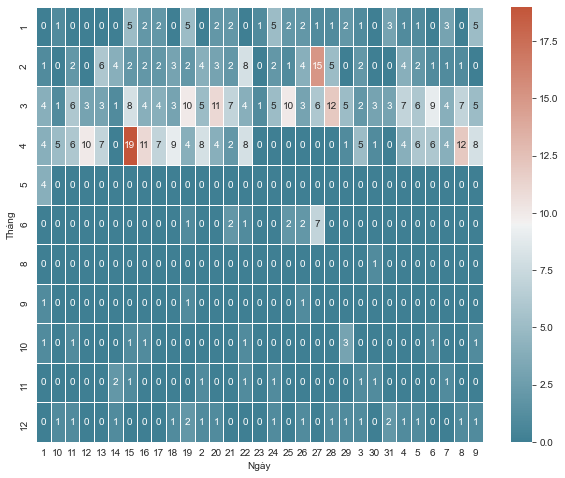

In [745]:
plt.subplots(figsize = (10,8))
sns.heatmap(df_20133, annot = True,
            linewidths = 0.5, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.xlabel("Ngày")
plt.ylabel("Tháng")

In [32]:
data = df.toPandas()

ValueError: Could not parse datatype: interval